# Citibike Ridership Modeling

This notebook contains the final models for Citibike Ridership as well as a brief description of iterations and grid searches performed to get to these final models. Full backup, including grid searches and other details, can be found in:
- **Overall Ridership**: notebooks/citibike_arima.ipynb
- **Neighborhood Level Modeling**: notebooks/citibike_arima_neighborhood.ipynb

# Modeling Summary

These modeled relied on statsmodels SARIMAX toolkit to train time series models and perform predictions. The 'S' is need to appropriately capture seasonality in the data while the 'X' was included in anticipation of including exogenous variables related to COVID-19.

### Goals
The main goal is to forecast expected ridership for the overall system and by neighborhood for 2022. A secondary objective is to say at what points in the year ridership is expected to peak and trough. Given this objective, I will need at least one year of data to train the model and a year to test it.


### Evaluation 
Models will be evaluated based primarily on Explained Variance, MAE, and RMSE, with R2 also among the results printed. Grid searches were performed based on maximizing Explained Variance, which is the main goal of hte modeling results.

The goal is to maximize Explained Variance and minimize MAE and RMSE.

### Weekly vs. Daily
The first model attempted to use daily data to create the yearly forecast. This performed poorly for a couple reasons: 
- ARIMA models are not well suited to using daily data to create such long-term forecasts.
- There are two seasonal components to the data: the yearly summer spike, which follows warmer weather and the weekly cadence that goes with commuting. ARIMA doesn't support seasonal lags as high as 365 so ultimately I was unable to appropriately capture these affects and the models performed poorly.

Further details can be found in the backup notebook (linked above). Only one is shown below just as an example.


### Covid-19
The start of the COVID-19 pandemic in March 2020 resulted in a precipitous decline in ridership in 2020 before recovery to record-breaking levels in 2021. Until I control for this by adding exogenous variables to the model, I have gone back and forth on how best to deal with this:
- **Final approach**: include COVID data in the training set. There are still enough months in the training set after this to approximate a "normalized environment". The risk is a slight underforecasting of future months, but still performs reasonably well. Another benefit is that the train / test splits will be the same when incorporating the COVID-19 controls.
- **Other approach**: exclude COVID from the training set. While this produces a slightly better performing model overall, certain neighborhoods that have had a slower return in ridership get really aggressive forecasts.

In [1]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from scipy.fft import fft, fftfreq, fftshift
import scipy
import itertools
from ast import literal_eval

# Set style
plt.style.use('seaborn')

In [2]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics, plot_results

In [8]:
# Modeling

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest

from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [9]:
def run_model(results, df_preds_, neighborhood, ts, order, seasonal_order, logged):
    
    '''
    Used for neighborhood-level modeling.
    Rest of docstring here.
    '''
    
    train = ts[ts['future'] == 0]
    test = ts[ts['future'] == 1]

    
    if logged:
        sari_model = SARIMAX(train['ride_count_log'], order=order, seasonal_order=seasonal_order).fit(maxiter=1000, disp=False)
    else:
        sari_model = SARIMAX(train['ride_count'], order=order, seasonal_order=seasonal_order).fit(maxiter=1000, disp=False)
    
    # Add preds to predictions DataFrame
    preds = sari_model.forecast(steps = len(test))
    if logged:
        df_preds_.loc[:,neighborhood] = np.exp(preds)
    else:
        df_preds_.loc[:,neighborhood] = preds
    
    # Retrieve metrics
    if logged:
        model_results = report_metrics(test['ride_count'], np.exp(preds), False)
    else:
        model_results = report_metrics(test['ride_count'], preds, False)
    
    # Calculate actual vs. predicted rides for 2021
    actual_rides_2021 = ts[ts.index > '12/31/2020']['ride_count'].sum()
    pred_rides_2021 = df_preds_[df_preds_.index > '12/31/2020'][neighborhood].sum()
    
    ride_delta = np.abs(pred_rides_2021 - actual_rides_2021)
    
    # Add results to results dataframe
    results.loc[neighborhood, 'model'] = sari_model
    results.loc[neighborhood, 'order'] = order
    results.loc[neighborhood, 'seasonal_order'] = seasonal_order
    results.loc[neighborhood, 'explained_variance'] = model_results[0]
    results.loc[neighborhood, 'MAE'] = model_results[1]
    results.loc[neighborhood, 'MSE'] = model_results[2]
    results.loc[neighborhood, 'R2'] = model_results[3]
    results.loc[neighborhood, '2021_actual'] = actual_rides_2021
    results.loc[neighborhood, '2021_predicted'] = pred_rides_2021
    results.loc[neighborhood, 'delta'] = ride_delta
    
    return results, df_preds_

In [10]:
def neighborhood_grid_search(pdq, seasonal_pdq, neighborhood, df, df_grid_search):
    
    # Set AIC to some high number to ensure at least one model is below
    best_aic = 10000000
    
    print(f"Currently working on: {neighborhood}")

    for param in pdq:
        for param_seasonal in seasonal_pdq: 
            mod = SARIMAX(df['ride_count_log'], order=param, seasonal_order=param_seasonal).fit(maxiter=1000)
                
            if mod.aic < best_aic:
                best_aic = mod.aic
                best_order = param
                best_s_order = param_seasonal
                df_grid_search.loc[neighborhood,:] = [best_order, best_s_order, best_aic]
    
    return df_grid_search

In [11]:
# Import clean dataset

df_citibike = pd.read_csv('./clean_data/final_clean_ridership.csv', low_memory=False)

In [12]:
# Convert starttime to date and set as index

df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])

df_citibike.set_index('starttime', inplace=True)

In [13]:
# Sense check output

df_citibike.head()

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2013-06-01,72,40.767272,-73.993929,40,2013,Clinton,Manhattan
2013-06-01,79,40.719116,-74.006667,61,2013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
2013-06-01,82,40.711174,-74.000165,6,2013,Chinatown,Manhattan
2013-06-01,83,40.683826,-73.976323,32,2013,Fort Greene,Brooklyn
2013-06-01,116,40.741776,-74.001497,53,2013,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan


In [14]:
# Create the daily file

daily_ridership = df_citibike[['ride_count']].resample('1D').sum()

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

In [15]:
# Define Train / Test split time

test_start = '2020-11-01'

## Naive Baseline

- Take average of the train data to predict the test
- Fit a simple linear regression
- The testing data will be from June 1st 2020 to June 1st 2021. This is to ensure that when I bring exogenous variables in down the line that the training data has some period from COVID to train on.

#### Average Baseline

In [16]:
# Inserting a time period track for our naive models

daily_ridership.insert(0, 't', range(len(daily_ridership)))

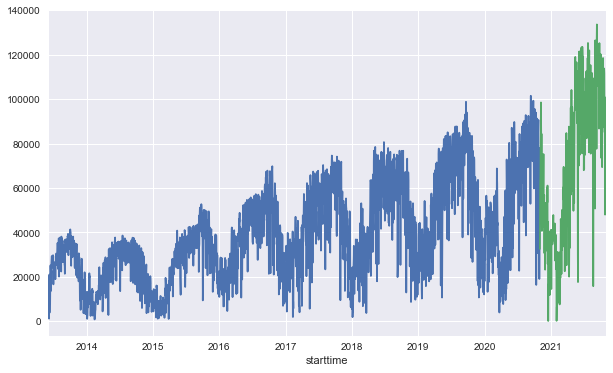

In [17]:
# Define bounds of train / test

daily_ridership['future'] = (daily_ridership.index >= test_start).astype('int')

# Now plot
plt.figure(figsize=(10,6))
daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot()
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot()
plt.show();

In [18]:
# Creating train test splits for our naive models

X_train = daily_ridership.loc[daily_ridership.future == 0, 't'].values.reshape(-1, 1)
X_test = daily_ridership.loc[daily_ridership.future == 1, 't'].values.reshape(-1, 1)

# The train set is the actual value in the series
y_train = daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].values
y_test = daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].values

In [19]:
# Naive baseline prediction, will take the average of the train data

y_preds = daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].mean()

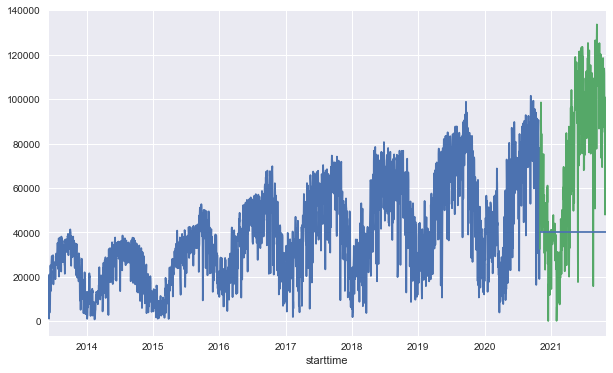

In [20]:
# Plot the baseline prediction

plt.figure(figsize=(10,6))
daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot()
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot()

# Predictions go here
plt.hlines(y=y_preds,
          xmin=daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].index[0],
          xmax=daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].index[-1])


plt.show();

In [21]:
# Show results of first naive model

y_preds = [y_preds] * len(y_test)

results = report_metrics(y_test, y_preds, True)

Explained Variance: 0.0000
MAE: 38,833.0573
RMSE: 47,228.7920
r^2: -0.9237


As expected, very poor performance across the key metrics

#### Simple Linear Regression

In [22]:
# Fit the linear model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)
y_trend_lr = lr.predict(X_train)

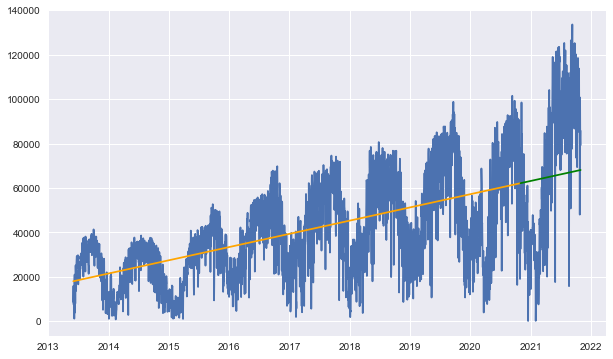

In [23]:
# Plot results

plt.figure(figsize=(10,6))
plt.plot(daily_ridership['ride_count'])
plt.plot(daily_ridership.loc[daily_ridership.future == 0].index, y_trend_lr, color='orange')
plt.plot(daily_ridership.loc[daily_ridership.future == 1].index, y_preds_lr, color='green')
plt.show()

In [24]:
# Evaluate linear regression

results = report_metrics(y_test, y_preds_lr, True)

Explained Variance: 0.0734
MAE: 29,922.2116
RMSE: 33,672.3303
r^2: 0.0221


Conclusions: While each of these models performs poorly, they give us a benchmark to compare against.

## First SARIMA model

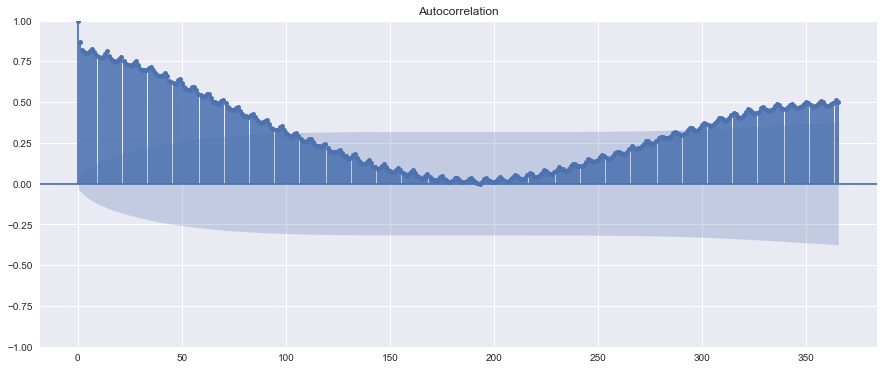

In [25]:
# In the ACF plot, you can clearly see the yearly seasonality in this data
# Less obvious (because of the scale) is the weekly trend as well

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_acf(daily_ridership['ride_count'], lags=365, ax=ax);

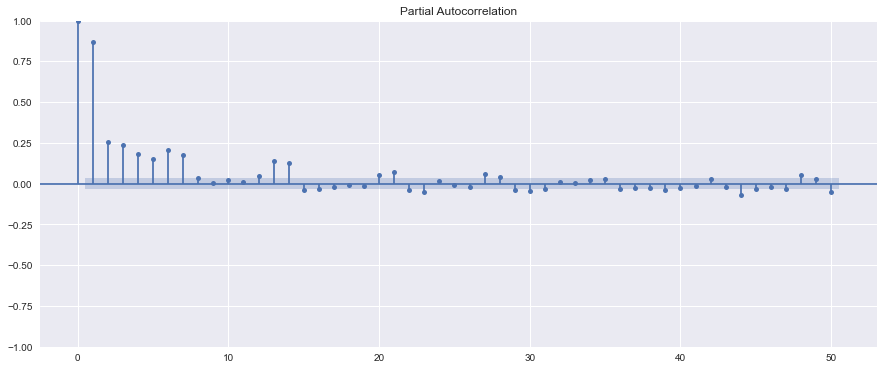

In [26]:
# In the PACF plot, you see more of the weekly trend instead of the seasonal trend

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_pacf(daily_ridership['ride_count'], method='ywm', lags=50, ax=ax);

In [27]:
# Just for illustrative purposes to how poorly it fits

seas_arima = ARIMA(daily_ridership.loc[daily_ridership.future == 0]['ride_count'], 
                   order = (1, 1, 1), seasonal_order=(0, 0, 0, 365))

baseline_sarima = seas_arima.fit()

In [28]:
# Create predictions based on the model and store it in a new dataframe

actuals = daily_ridership.loc[daily_ridership.future == 1]['ride_count']
preds = baseline_sarima.forecast(steps = len(daily_ridership.loc[daily_ridership.future == 1]))


# Print metric summary

results = report_metrics(actuals, preds, True)

Explained Variance: -0.0002
MAE: 31,265.6581
RMSE: 35,075.7551
r^2: -0.0611


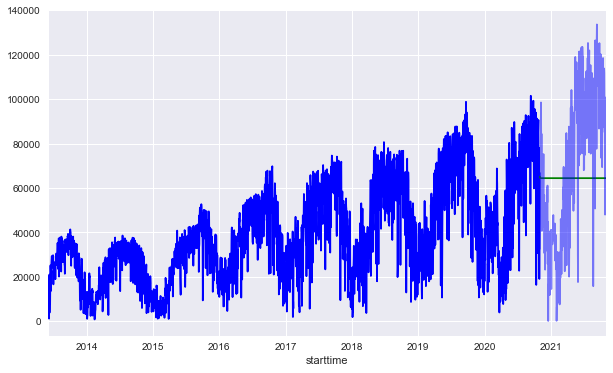

In [29]:
# Plot the results

plot_results(daily_ridership, preds, False)

Not good!

## Weekly Ridership

- Now, will move on to the core of the modeling, which will involve re-aggregated weekly data

In [30]:
# Resample to weekly

weekly_ridership = daily_ridership.resample('W-SUN').sum().drop('future', axis=1)

weekly_ridership.drop('t', axis=1, inplace=True)

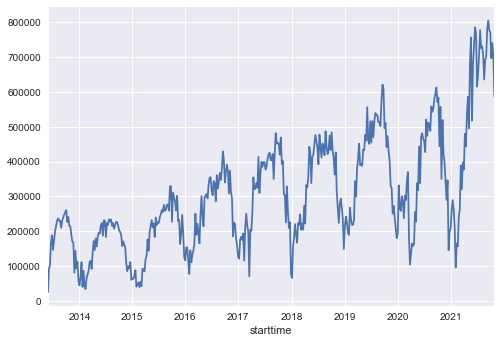

In [31]:
# Plot the new data

weekly_ridership['ride_count'].plot();

# A lot cleaner than the daily data

In [32]:
# RUn dickey fuller on unadjusted data

dickey_fuller(weekly_ridership['ride_count'], False, True)

# This is actually showing us that it's stationary, but it's close enough that I'll still want to log transform.

Data is stationary. P-value of 0.0132


(True, 0.013159368867778168)

In [33]:
# Create future time stamp

weekly_ridership['future'] = (weekly_ridership.index >= test_start).astype('int')

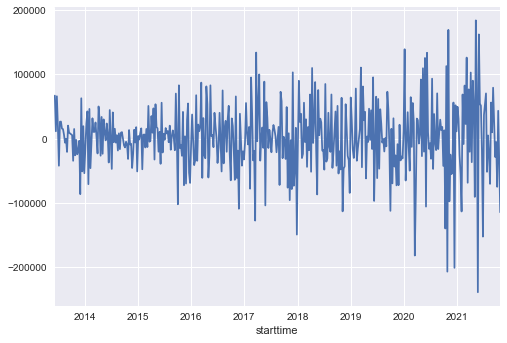

In [34]:
# Plot the 1d diff to visualizing inspect for stationarity

weekly_ridership['1d_diff'] = weekly_ridership['ride_count'].diff()

weekly_ridership['1d_diff'].plot();

# There is increasing variance still, further evidence that I want to log transform

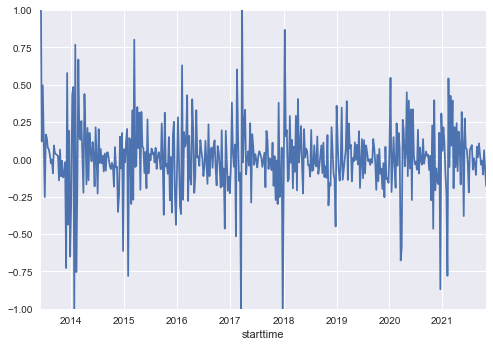

In [35]:
# The log of ride count with the 1d diff looks very stationary, plus we have the obvious 52 week 
# seasonality factor to consider as an input

fig, ax = plt.subplots()

ax.set_ylim([-1, 1])

weekly_ridership['ride_count_log'] = weekly_ridership['ride_count'].apply(lambda x: np.log(x))

weekly_ridership['ride_count_log'].diff().plot(ax=ax);

In [36]:
# Create train test splits

train_weekly = weekly_ridership[weekly_ridership['future'] == 0]['ride_count_log']
test_weekly = weekly_ridership[weekly_ridership['future'] == 1]['ride_count_log']

In [38]:
# First seasonal model without grid search, using 52 weeks lag

seas_mod_weekly = SARIMAX(train_weekly, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52)).fit(disp=False)

weekly_future_df = weekly_ridership.loc[weekly_ridership.future == 1].copy()

weekly_future_df['baseline_seas'] = seas_mod_weekly.forecast(steps = len(test_weekly))

results = report_metrics(np.exp(test_weekly), np.exp(weekly_future_df['baseline_seas']), True)

Explained Variance: 0.6801
MAE: 116,059.8017
RMSE: 139,927.5647
r^2: 0.5817


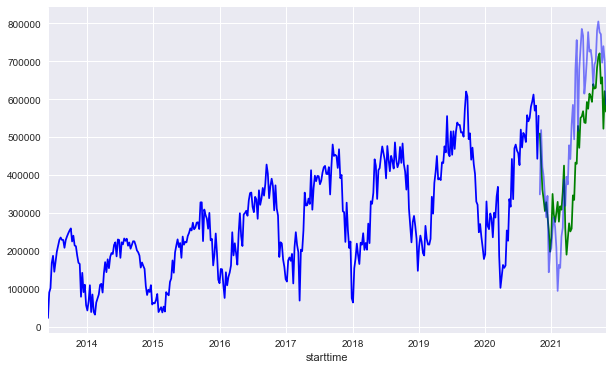

In [39]:
# Plot the results

plot_results(weekly_ridership, weekly_future_df['baseline_seas'], True)

Explain variance of 68% and R2 of 0.58 is pretty good without grid searching!

In [51]:
# Create tuples of every p, d, q combination for 0 and 1

p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

# Set initial EV to some initially low amount
best_ev = 0

for param in pdq:
    for param_seasonal in seasonal_pdq: 
        mod = SARIMAX(train_weekly, order=param, seasonal_order=param_seasonal).fit(maxiter=1000, disp=False)
        
        forecast = mod.forecast(steps = len(test_weekly))
        ev = metrics.explained_variance_score(np.exp(test_weekly), np.exp(forecast))

        if ev > best_ev:
            best_ev = ev
            best_order = param
            best_s_order = param_seasonal

In [52]:
# Display results of grid search

print(best_ev, best_order, best_s_order)

0.865850605266835 (1, 1, 0) (0, 1, 1, 52)


In [62]:
# Evaluate model with grid search results

seas_mod_best = SARIMAX(train_weekly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

weekly_future_df['best_seas'] = seas_mod_best.forecast(steps = len(test_weekly))

results = report_metrics(np.exp(test_weekly), np.exp(weekly_future_df['best_seas']), True)

# Note (0, 1, 1) and (0, 1, 1, 52) produces similar results but without as aggressive of a 2022 projection

Explained Variance: 0.8659
MAE: 64,183.1678
RMSE: 79,302.1376
r^2: 0.8656


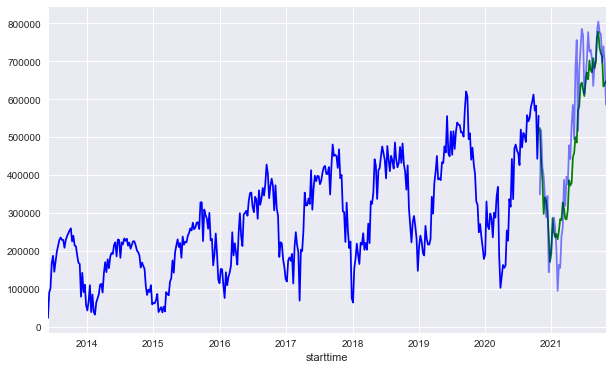

In [57]:
# Plot the results

plot_results(weekly_ridership, weekly_future_df['best_seas'], True)

Conclusion: zeroing out the first seasonal AR term results in significantly higher performance. Explained variance is 87% and R2 and 0.86. This feels excellent. To sense check, I will just forecast out to 2022 to ensure the trend is what we'd expect.

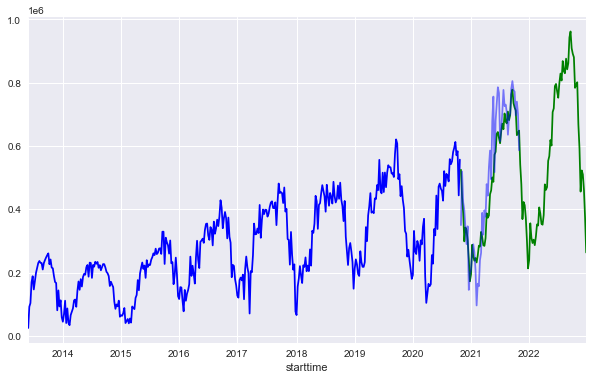

In [58]:
# Sense check plot on the 2022 predictions

plot_results(weekly_ridership, seas_mod_best.forecast(steps = len(test_weekly) + 60), True)

#### Model Evaluation

The only drawback to these parameters is that it produces a very aggressive 2022, although this appears to be in line with the increasing trend that we see in the data. As Citibike continues to add more neighborhoods and stations, we may very well shatter the ridership record in 2022. The risk to this forecast is that Citibike is unable to have the bikes in the system to meet this demand (they have already said that this has been an issue in 2021). There is a version of the parameters that fits reasonably well on 2021, but produces a less aggressive 2022 forecast (4mm fewer rides in total). This may be an alternative verison of the final model.

In [89]:
# Set final model = to the grid searched version

final_overall_model = seas_mod_best

## Neighborhood modeling

- Below will create models for each of the neighborhoods in Manhattan. There are three steps to the process:
    - Initial model run based on best parameters for the overall dataset
    - Grid search for each of the neighborhoods
    - Manual tuning where necessary for certain neighborhoods

#### Initial Data Processing and Prep

Process neighborhood-level DataFrames
- Resample weekly
- Log transform ridership count
- Create a dataframe to store results

In [66]:
# Read in clean neighborhood list and convert to list

temp_df = pd.read_csv('./clean_data/neighborhood_list.csv', low_memory=False)

neighborhood_list = list(temp_df.iloc[:,1])

In [67]:
# Process each of the DFs in the neighborhood list

df_dict = {}

for neighborhood in neighborhood_list:
    df = process_neighborhood(df_citibike, neighborhood)
    df_dict[neighborhood] = df

In [68]:
# Resample for weekly given better performance of overall model on weekly data

for neighborhood, df in df_dict.items():
    df_dict[neighborhood] = df[['ride_count']].resample('W-SAT').sum()

In [69]:
# Add a future tag after the cut off for easy designation of train / test split

for neighborhood, df in df_dict.items():
    
    df['future'] = (df.index >= test_start).astype('int')
    
    df_dict[neighborhood] = df

In [70]:
# Create a dataframe to store neighborhood by neighborhood results

df_results = pd.DataFrame(index=neighborhood_list, columns=['model', 'order', 'seasonal_order',
                                                            'explained_variance', 'MAE', 'MSE', 'R2',
                                                            '2021_actual', '2021_predicted', 'delta', 
                                                            'requires_log'])

In [71]:
# Create another dataframe to store the predictions from each model

df_preds = pd.DataFrame(index=df_dict['Clinton'][df_dict['Clinton'].index >= test_start].index, 
                              columns=neighborhood_list)

In [72]:
# Add a column to each neighborhood dataframe with the log transformed ridership

for neighborhood, df in df_dict.items():

    df_results.loc[neighborhood, 'requires_log'] = True
    df['ride_count_log'] = df['ride_count'].apply(lambda x: np.log(x))
    df_dict[neighborhood] = df

#### First Neighborhood Model

Uses the hyperparemeters that produced the optimal overall model

In [51]:
# Run models for each neighborhood. Use parameters that performed best on overall model.
# Note: takes ~20 minutes to run

for neighborhood, df in df_dict.items():
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, df, 
                                    (1, 1, 0), (0, 1, 1, 52), 
                                    df_results.loc[neighborhood, 'requires_log'])

/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [52]:
# There are 13 neighborhoods with R2 below 0.25

df_results[df_results['R2'] < 0.25].shape

(15, 11)

In [ ]:
# Define range of p, d, q, and P, D, Q for neighborhood grid search

p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))

In [94]:
df_grid_search = pd.DataFrame(index=neighborhood_list, columns=['order', 's_order', 'aic'])

#### Neighborhood Grid Search

The code below takes ~3 hours to run. Optimal orders and seasonal_orders (minimizing AIC) by neighborhood were stored and exported to save time on future runs.

In [ ]:
# Commented out: code below takes ~3 hours to run

# for neighborhood, df in df_dict_covid.items():
#     df_grid_search = neighborhood_grid_search(pdq, seasonal_pdq, neighborhood, df, df_grid_search)

In [63]:
# Save the results so we don't have to re-run the 3 hour long function again

# df_grid_search.to_csv('./results/neighborhood_grid_search.csv')

# If needed, load neighborhood grid search (if not running full notebook)

df_grid_search = pd.read_csv('./results/neighborhood_grid_search.csv', index_col=0)

# Convert order / s_orders string via literal eval
df_grid_search['order'] = df_grid_search['order'].apply(lambda x: literal_eval(x))
df_grid_search['s_order'] = df_grid_search['s_order'].apply(lambda x: literal_eval(x))

In [73]:
# Rerun COVID neighborhood models with the result of the grid search

for neighborhood, df in df_dict.items():
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, df, 
                                     df_grid_search.loc[neighborhood,'order'], 
                                     df_grid_search.loc[neighborhood,'s_order'], 
                                     df_results.loc[neighborhood, 'requires_log'])

/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zer

In [74]:
# Take a closer look at neighborhoods with poor performance to see if there's an opportunity to manually tune

r2_threshold = 0.25

df_tune = df_results[df_results.loc[:,'R2'] < r2_threshold]

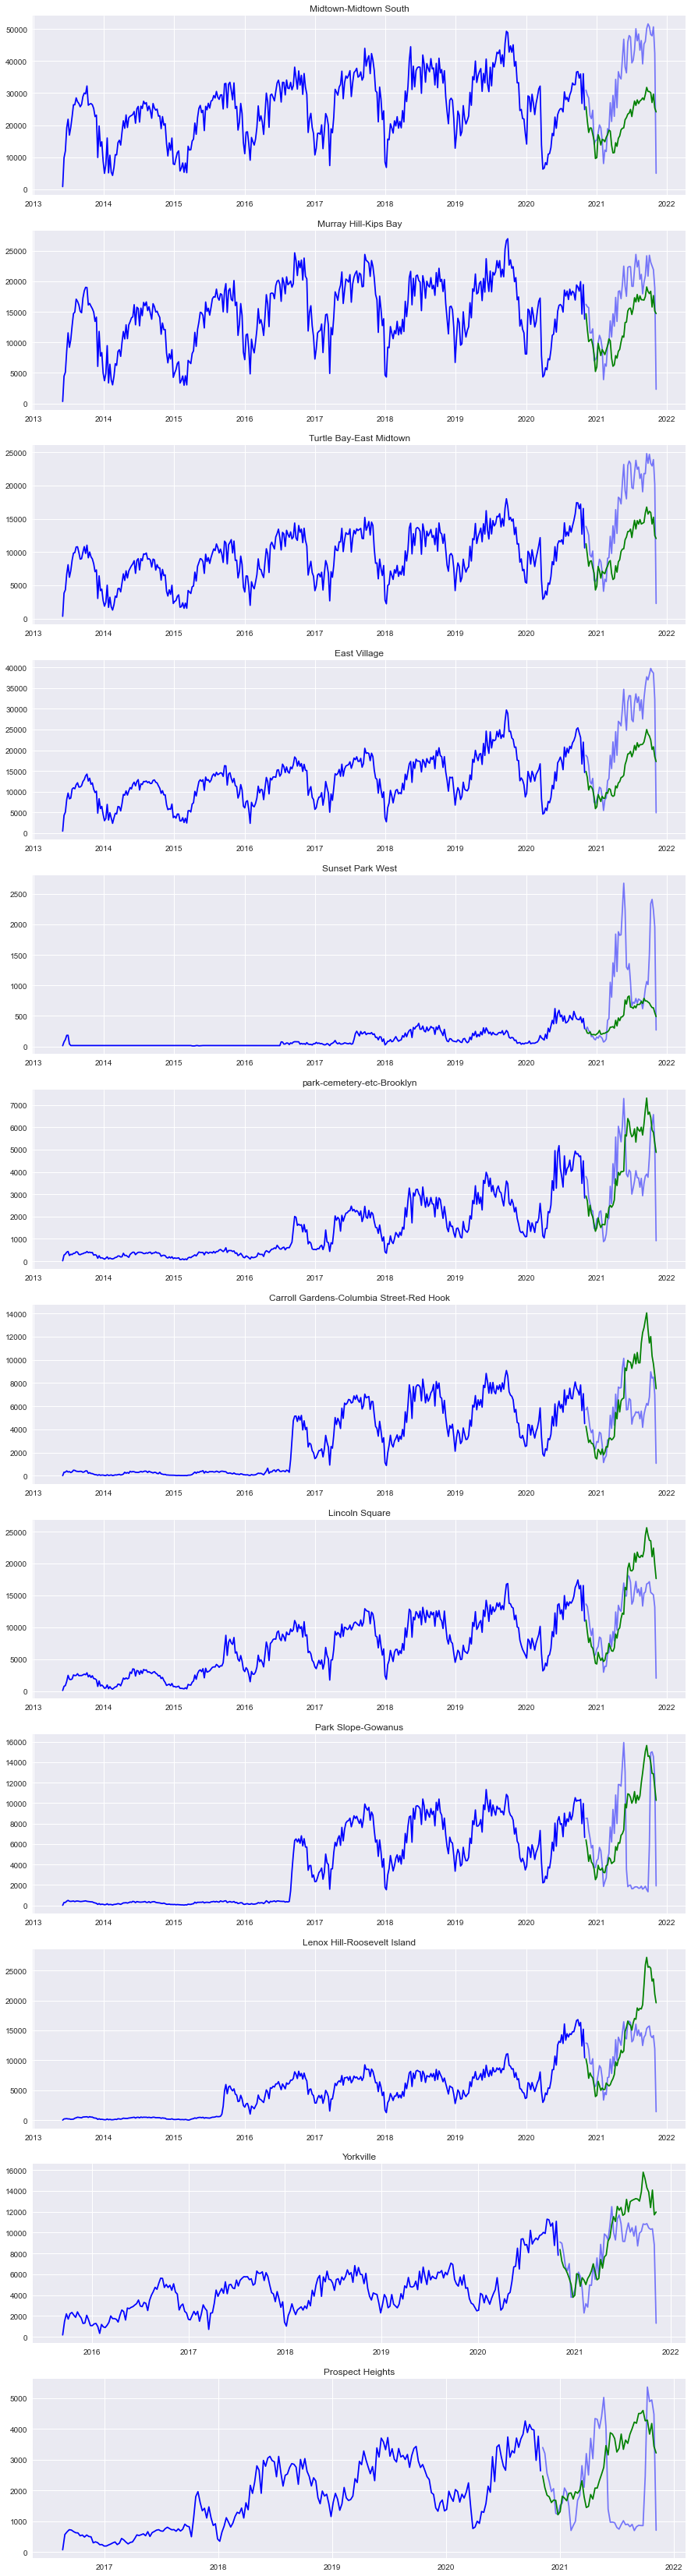

In [76]:
# Plot each of the predictions from these neighborhoods to sense check the results

fig, ax = plt.subplots(nrows=(len(df_tune.index)), figsize=(15,60))

for i, neighborhood in enumerate(df_tune.index):
    ax[i].plot(df_dict[neighborhood].loc[df_dict[neighborhood].future == 0, 'ride_count'], color='blue')
    ax[i].plot(df_dict[neighborhood].loc[df_dict[neighborhood].future == 1, 'ride_count'], color='blue', 
               alpha=0.5)
    
    ax[i].plot(df_preds.loc[:,neighborhood], color='green')
    ax[i].set_title(neighborhood)

#### Neighborhood level tuning conclusions:
- There are a few neighborhoods, mostly in Manhattan, where the model "under-predicts" ridership, likely because it has no way to anticipate the surge in ridership from people coming back into the office
    - Midtown-Midtown South, Murray Hill-Kips Bay, Turtle Bay-East Midtown, East Village
- The second category of miss is those neighborhoods with an apparent data issue. During the summer of 2021, ridership falls off for a few Brooklyn neighborhoods, which appears to be a data issue. These are:
    - Propect Heights, Park Slope-Gowanus, Carrol Gardens, Park Cemetery, Brooklyn.
- There are also some neighborhoods on the Upper East side (Yorkville, Lenox Hill) where ridership has not recovered
- Sunset Park west appears to have the opposite problem with a suspcious dual spike in ridership.

#### Next steps:
- Further tune Manhattan and UES neighborhoods
- Don't tune the neighborhoods with data issues any further (the poor metrics are due to data issues in the Testing data)

#### Backup:
- I haven't already done the tuning in notebooks/citibike_arima_neighborhood to try to manually improve performance. Rather than re-run those steps here, I will just skip to re-running the models based on the optimal metrics.

**Midtown**: It's clear I'm not going to be able to capture the recovery in ridership without some control for COVID. Removing the AR term and giving the model 2 MA terms does stop the donward trend in the prediction. This is the best that I can do for now. 

**UES**: For the neighborhoods where the model was materiall overprojecting, removing the differencing term actually appears to prevent the aggressive forecast. I'm still comfortable that the data is stationary without this differencing term given that the time series has been logged.

In [77]:
df_tune

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.499271,13330.036737,15330.071091,-0.297083,1562113,968326.960471,593786.039529,True
Murray Hill-Kips Bay,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.553169,4560.342179,5438.738345,0.168539,754790,575339.367176,179450.632824,True
Turtle Bay-East Midtown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.602439,5704.556092,6629.079053,0.041522,753899,500358.747678,253540.252322,True
East Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.623278,8779.645104,10416.293199,0.052337,1116657,707320.406099,409336.593901,True
Sunset Park West,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(1, 1, 1, 52)",0.227926,515.131091,797.237538,-0.178518,47977,23109.207619,24867.792381,True
park-cemetery-etc-Brooklyn,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(0, 1, 1, 52)",-0.100805,1376.066831,1738.626117,-0.211227,167600,198437.744953,30837.744953,True
Carroll Gardens-Columbia Street-Red Hook,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",-1.412219,2799.861656,3578.147281,-1.896814,243325,330691.407029,87366.407029,True
Lincoln Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",-0.009447,3791.175147,4785.831292,-0.149983,547137,653844.34546,106707.34546,True
Park Slope-Gowanus,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",-0.98994,5126.349991,6501.235355,-1.196455,263480,383457.550408,119977.550408,True
Lenox Hill-Roosevelt Island,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(0, 1, 1, 52)",-0.944961,4045.971898,5534.561688,-1.111472,531047,632964.638547,101917.638547,True


In [78]:
midtown_neighborhoods = ['Midtown-Midtown South', 'Murray Hill-Kips Bay', 'Turtle Bay-East Midtown', 
                         'East Village']

ues_neighborhoods = ['Yorkville', 'Lenox Hill-Roosevelt Island', 'Lincoln Square']

In [79]:
# Re-run midtown models with updated tuning

for neighborhood in midtown_neighborhoods:
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, 
                                     df_dict[neighborhood], (0, 1, 2), (1, 1, 1, 52), 
                                     df_results.loc[neighborhood, 'requires_log'])

In [80]:
# Re-run UES models with updated tuning

for neighborhood in ues_neighborhoods:
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, 
                                     df_dict[neighborhood], (1, 0, 1), (1, 1, 0, 52), 
                                     df_results.loc[neighborhood, 'requires_log'])

In [81]:
final_results = df_results

## Generate 2022 forecast
- Next step is to generate the 2022 forecast for the overall ridership and neighborhood level models

In [82]:
# Create an empty forecast dataframe

# Previously calibrated forecast steps to go through the end of 2022
forecast_steps = 112

df_forecast = pd.DataFrame(index=final_results.loc['Clinton', 'model'].forecast(steps=forecast_steps).index,
                           columns=neighborhood_list)

In [83]:
# Add the forecast from each model to the dataframe

for neighborhood in neighborhood_list:
    
    model = final_results.loc[neighborhood, 'model']
    forecast = np.exp(model.forecast(steps = forecast_steps))
    
    df_forecast.loc[:,neighborhood] = forecast

In [84]:
# Create column to store 2022 predictions
df_results['2022_predicted'] = np.nan

# Filter forecast DF down to 2022 only
df_2022_forecast = df_forecast[(df_forecast.index > '12/31/2021') & (df_forecast.index < '12/31/2022')]

for neighborhood in neighborhood_list:
    final_results.loc[neighborhood, '2022_predicted'] = df_2022_forecast.loc[:,neighborhood].sum()

In [85]:
final_results

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log,2022_predicted
Clinton,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.726332,3812.312408,4452.958097,0.513537,706840,562145.199333,144694.800667,True,6.907988e+05
SoHo-TriBeCa-Civic Center-Little Italy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.778551,7241.183106,8560.737376,0.566014,1266160,975836.487712,290323.512288,True,1.206766e+06
Chinatown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.807424,2499.674081,3217.607285,0.719602,676262,595935.469043,80326.530957,True,8.626155e+05
Fort Greene,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.710188,1745.316694,2073.296976,0.464661,309627,243007.762776,66619.237224,True,3.559998e+05
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.655583,14529.122275,16987.120162,0.270047,2190634,1583591.332244,607042.667756,True,1.829224e+06
Bedford,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.403573,1161.890369,1484.878381,0.267971,207296,244919.85728,37623.85728,True,3.941426e+05
West Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.783835,8948.186457,10715.469755,0.609107,1571664,1227584.67731,344079.32269,True,1.860169e+06
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 2)","(1, 1, 1, 52)",0.511241,13199.855604,15195.273763,-0.274372,1562113,974033.065542,588079.934458,True,1.150142e+06
Brooklyn Heights-Cobble Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.721584,1649.278105,1916.744077,0.344719,247070,176260.941306,70809.058694,True,2.266473e+05
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.795017,2881.958711,3392.432518,0.561301,537851,421317.891515,116533.108485,True,5.752134e+05


In [86]:
# Fill in the remaining two months from 2021 from the forecast

final_results['pro_rata_2021'] = np.nan

for neighborhood, df in df_dict.items():
    
    final_results.loc[neighborhood, 'pro_rata_2021'] = final_results.loc[neighborhood, '2021_actual'] + \
                                                            df_forecast[(df_forecast.index < '1/1/2022') & 
                                                                        (df_forecast.index > '10/31/2021')][neighborhood].sum()

In [87]:
# Add a 2022 forecast column to the results dataframe

final_results['forecast_2022'] = np.nan

for neighborhood, df in df_dict.items():
    final_results.loc[neighborhood, 'forecast_2022'] = df_forecast[(df_forecast.index > '12/31/2021')][neighborhood].sum()

In [94]:
final_results.head()

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log,2022_predicted,pro_rata_2021,forecast_2022
Clinton,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.726332,3812.312408,4452.958097,0.513537,706840,562145.199333,144694.800667,True,6.907988e+05,7.826016e+05,6.907988e+05
SoHo-TriBeCa-Civic Center-Little Italy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.778551,7241.183106,8560.737376,0.566014,1266160,975836.487712,290323.512288,True,1.206766e+06,1.386265e+06,1.206766e+06
Chinatown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.807424,2499.674081,3217.607285,0.719602,676262,595935.469043,80326.530957,True,8.626155e+05,7.590812e+05,8.626155e+05
Fort Greene,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.710188,1745.316694,2073.296976,0.464661,309627,243007.762776,66619.237224,True,3.559998e+05,3.435006e+05,3.559998e+05
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.655583,14529.122275,16987.120162,0.270047,2190634,1583591.332244,607042.667756,True,1.829224e+06,2.400066e+06,1.829224e+06


In [95]:
# Add ride growth and % growth columns for 2022

final_results['delta_2022'] = final_results['forecast_2022'] - final_results['pro_rata_2021']

final_results['percent_chg_2022'] = (final_results['forecast_2022'] - final_results['pro_rata_2021']) / final_results['pro_rata_2021']

In [90]:
# Generate overall 2022 prediction

# Previously calibrated forecast steps to go through the end of 2022
forecast_steps = 113

overall_preds = pd.DataFrame(index=final_overall_model.forecast(steps=forecast_steps).index,
                             columns=['preds'])

overall_preds['preds'] = np.exp(final_overall_model.forecast(steps=forecast_steps))

pro_rata_2021 = weekly_ridership[weekly_ridership.index > '12/31/2020']['ride_count'].sum() + \
                overall_preds[(overall_preds.index > '10/31/2021') & (overall_preds.index < '1/1/2022')]['preds'].sum()

overall_2022 = overall_preds[overall_preds.index > '12/31/2021']['preds'].sum()

print(f"In 2021, there were {pro_rata_2021:,.0f} rides")
print("")
print(f"In 2022, there are forecast to be {overall_2022:,.0f} rides")

In 2021, there were 27,254,425 rides

In 2022, there are forecast to be 35,922,243 rides


## Conclusions

#### Final Overall Model

- The final overall model produces excellent results on the test set, with explained variance of 87%. 
- The downside to the hyperparemeters that produce this result is a very aggressive 2022 forecast. Rides are forecast at 36mm, up from 27mm in 2021 (a record year in its own right). While the trend in the data does suggest this trajectory is reasonable, Citibike may run into logistical challenges in meeting this demand (they have already said there have been some struggles with record ridership in 2021 alone).

In [92]:
results = report_metrics(np.exp(test_weekly), np.exp(weekly_future_df['best_seas']), True)

Explained Variance: 0.8659
MAE: 64,183.1678
RMSE: 79,302.1376
r^2: 0.8656


#### Neighborhood Models:

- Most neighborhoods have a model with an explained variance of at least 50%. For those models that continue to perform poorly, there are two explanations:
    - Midtown Manhattan neighborhoods where the model has failed to predict the extent of the post-COVID recovery
    - Adjacent neighborhoods around prospect park where there is an apparent data issue for a couple months in 2021 (which results in poor performance on the holdout test set)
- While I don't have a solution to the data issues in Brooklyn, one next step for the midtown neighborhood is to incorporate exogenous COVID variables, which will hopefully explain more of the recovery seen as the city opened up.

**Key Results**

- The top 5 neighborhoods in terms of overall ride growth are all grouped around Prospect Park in Brooklyn: Cemetery, Bushwich South, Park Slope, Carroll Gardens / Red Hook, and North Side. These are all neighborhoods where Citibike has recently expanded in the past several years, and the model expects them to continue to experience very rapid growth.
- These are also the neighborhoods that are expected to have the highest % change in ridership as well, all above 75% growth. In addition, Long Island City in Queens makes this list. 

**Next Steps / Improvements**

- Incorporate exogenous COVID variables. The model is doing a poor job at forecasting the massive growth in midtown Manhattan neighborhoods as more people have returned to office.
- There are many additional analyses to be run here. As another next step, I want to go even more granular than the daily data, and aggregate by ridership in discrete blocks during the day (i.e., morning commute, midday, and evening commute). By also preserving the destination station data, you can start to paint a picture of how people move about the system at a much more granular level.

In [98]:
# Sort values by change in ridership

final_results.sort_values(by='delta_2022', ascending=False)[['delta_2022']].head()

,delta_2022
park-cemetery-etc-Manhattan,452115.533167
Bushwick South,446360.061387
Park Slope-Gowanus,381480.850782
Carroll Gardens-Columbia Street-Red Hook,356233.111053
North Side-South Side,351156.678314


In [101]:
# Sort values by % change in ridership

final_results.sort_values(by='percent_chg_2022', ascending=False)[['percent_chg_2022']].head()

,percent_chg_2022
Carroll Gardens-Columbia Street-Red Hook,1.252871
Bushwick South,1.219686
Park Slope-Gowanus,1.187382
Queensbridge-Ravenswood-Long Island City,0.743205
park-cemetery-etc-Brooklyn,0.742575
